# Counting Boats from Space - Part 2

In [1]:
%reload_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
%matplotlib inline

## 1. Install, Import requirements

In [2]:
import sys
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision
!{sys.executable} -m pip install plotly

In [3]:
# Various utilities
import os
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage
import torch
from torch.utils.data import DataLoader

In [4]:
from src.dataset import getImageSetDirectories, S2_Dataset, plot_dataset
from src.model import Model
from src.train import train, get_failures_or_success

In [5]:
torch.cuda.is_available() # gpu support

False

## 2. Init K-Fold Dataset

In [6]:
data_dir = "/home/jovyan/data" # data directory (path)
checkpoint_dir = "/home/jovyan/checkpoints"
bands = ['img_08', 'bg_ndwi']
test_size = 0.2

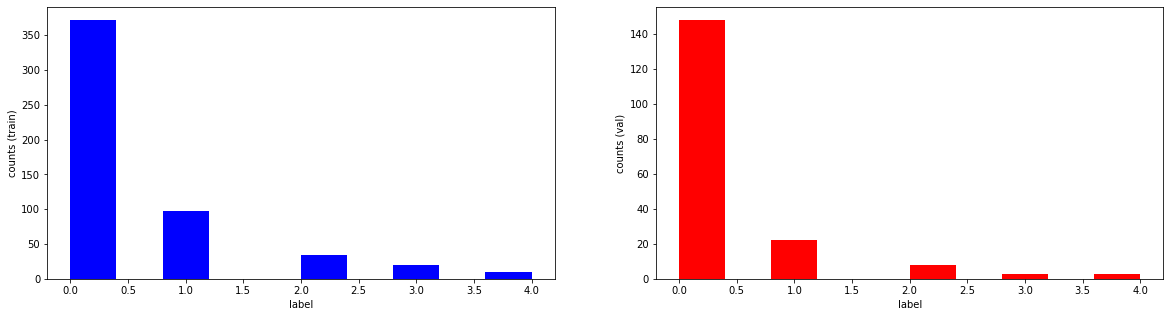

In [7]:
train_list, val_list, fig = getImageSetDirectories(data_dir=os.path.join(data_dir, 'chips'), band_list=bands, test_size=test_size, plot_coords=False, plot_class_imbalance=True, use_KFold=True, seed=123)
fig # mapbox plot train/val coordinates

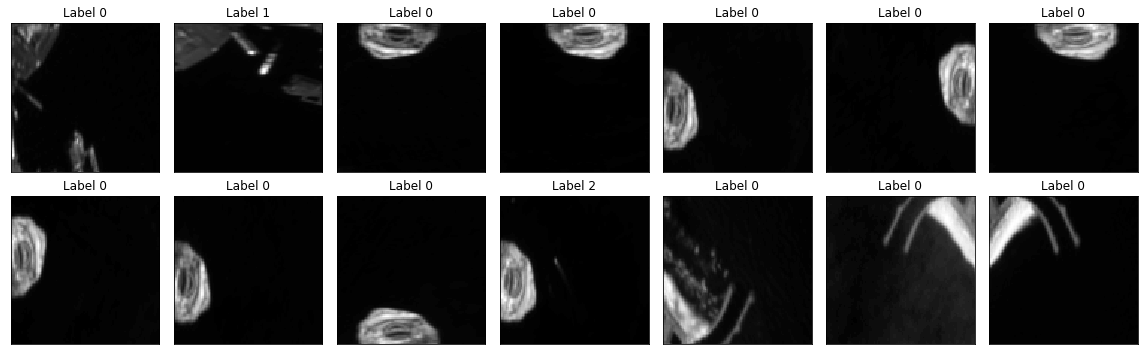

In [8]:
train_dataset = S2_Dataset(imset_dir=train_list[0], augment=True)
val_dataset = S2_Dataset(imset_dir=val_list[0], augment=False)
plot_dataset(train_dataset, n_frames=14, n_rows=2, cmap='gray')

## 4. Train PyTorch Classifier

In [9]:
# training config
input_dim = train_dataset[0]['img'].shape[0]
hidden_dim, kernel_size, pool_size, n_max = 16, 3, 10, 1

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=16)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

best_metrics = train(train_dataloader=train_dataloader, val_dataloader=val_dataloader,
             input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, pool_size=pool_size, n_max=n_max, drop_proba=0.15,
             ld=0.2, water_ndwi=0.4,
             n_epochs=100, lr=0.007, lr_step=2, lr_decay=0.95,
             device='cpu', checkpoints_dir=checkpoint_dir, seed=42, verbose=1, version='0.0.2')

Number of trainable params 5286


Epoch 1: train_clf_error 1.42560 / train_reg_error 3.66693 / val_clf_error 0.65965 / val_reg_error 1.96765
Epoch 2: train_clf_error 1.04409 / train_reg_error 1.14271 / val_clf_error 0.55348 / val_reg_error 1.90054
Epoch 3: train_clf_error 1.05071 / train_reg_error 1.16307 / val_clf_error 0.56422 / val_reg_error 1.30166
Epoch 6: train_clf_error 0.97655 / train_reg_error 0.86807 / val_clf_error 0.59510 / val_reg_error 0.67142
Epoch     9: reducing learning rate of group 0 to 6.6500e-03.
Epoch    12: reducing learning rate of group 0 to 6.3175e-03.
Epoch 13: train_clf_error 0.86159 / train_reg_error 0.89566 / val_clf_error 0.62677 / val_reg_error 0.31186
Epoch 14: train_clf_error 0.85794 / train_reg_error 0.85779 / val_clf_error 0.54451 / val_reg_error 0.58542
Epoch    17: reducing learning rate of group 0 to 6.0016e-03.
Epoch 18: train_clf_error 0.82461 / train_reg_error 0.81875 / val_clf_error 0.54130 / val_reg_error 0.48122
Epoch 21: train_clf_error 0.74212 / train_reg_error 0.76400 / 

In [ ]:
# Epoch 72: train_clf_error 0.11907 / train_reg_error 0.17316 / val_clf_error 0.04312 / val_reg_error 0.07061
# Epoch 62: train_clf_error 0.11637 / train_reg_error 0.15685 / val_clf_error 0.02619 / val_reg_error 0.08079

In [ ]:
for k,v in best_metrics.items():
    print('{} {:.4f}'.format(k,v))

## 5. Test Model

In [ ]:
# load pretrained model
model = Model(input_dim=input_dim, hidden_dim=hidden_dim, kernel_size=kernel_size, pool_size=pool_size, n_max=n_max, device='cpu', version='0.0.1')
checkpoint_file = os.path.join(checkpoint_dir, model.folder, 'model.pth')
model.load_checkpoint(checkpoint_file=checkpoint_file)
model = model.eval()

In [ ]:
# Display failures (train, val), scatter plot (Predicted vs True) and inspect hidden channels --> Re label?
get_failures_or_success(model, val_dataset, hidden_channel=1, success=None, filter_on=None, plot_heatmap=False)